**Data 612: Project 3 - Matrix Factorization Methods<br>Christina Valore, Juliann McEachern, & Rajwant Mishra<br>Due: June 25, 2019**

<h1 align="center">Goodreads Recommender Systems</h1>

<h2 style="color:#088A68;">Getting Started</h2>

For project 3, we choose to continue our work with Goodreads books and build a recommender system that utilizes implicit matrix factorization techniques. As we have learned, singular value decomposition (SVD) matrices can be computationally expensive. Thus, our work will focus on a small subset of Goodreads book data that we previously explored in [Project 2](https://nbviewer.jupyter.org/github/jemceach/612-group/blob/master/project-2/report.ipynb). 

We will also compare the performance of our functions and calculations to the results generated by the `surprise` package. 

#### Python Dependencies

In [152]:
# The usual suspects 
import numpy as np, pandas as pd 

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Scikits packages
## Suprise!
from surprise.model_selection import train_test_split as tts
from surprise import KNNWithMeans, SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split

## TFIDF
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer


#### Data Preparation  

Data was loaded from our Project 2 repository collection of Goodread books, ratings, and tags. Tranformations then were used to combine the datasets. 

In [153]:
# Load data into respective frames
books = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/books.csv',memory_map=True,engine='c', usecols=['goodreads_book_id','book_id', 'title', 'authors'])
ratings = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/ratings.tar.gz', 
                      compression='gzip', usecols=['user_id','book_id', 'rating'],memory_map=True,engine='c',skiprows=[5976480])
tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/book_tags.csv', engine='c', usecols=['goodreads_book_id','tag_id'],memory_map=True)
tag_id = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/tags.csv',memory_map=True,engine='c')

# transformations to join dataframes
book_tags = tags.set_index('tag_id').join(tag_id.set_index('tag_id')).merge(books, on='goodreads_book_id', how="inner")
data = ratings.set_index('book_id').join(books.set_index('book_id')).drop('goodreads_book_id', axis=1).reset_index()

#### Content-Based Data Subset

We revisited our content-based filtering function from Project 2 to optimize our subset of 10,000 goodread's books. We used this function to narrow down 100 books related to the novel, "Pride and Prejudice". 

In [4]:
# Reused CBF TFIDF to create best subset for analysis
CBF = book_tags.groupby(['goodreads_book_id','book_id','title','authors'],as_index=False).agg(lambda x:', '.join(x)).rename({'tag_name':'tags'}, axis=1).drop('goodreads_book_id', axis=1)
tdv = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english') # create vector
tfidf = tdv.fit_transform(CBF['tags']) # apply tfidf vector
cos = linear_kernel(tfidf, tfidf) # cosine similarity
i = pd.Series(data=CBF.index, index=CBF['title']) # index book_id for function

# Recommendation function 
def recommend(title):
    subset = CBF[['book_id','title', 'authors']] # set recommendation output
    idx = i[title] # set index to title
    #subset cos score
    score = pd.DataFrame(enumerate(cos[idx]), columns=['ID', 'score']).drop('ID', axis=1).sort_values('score', ascending = False).iloc[1:,]
    # recommend 100 books with some relation
    top_n = score[0:100]
    rec = subset.iloc[top_n.index].join(top_n).drop('score',axis=1)
    rec.index = np.arange(1, len(rec) + 1)
    return rec

recommended=recommend("Pride and Prejudice").merge(data, on=['book_id', 'title', 'authors'], how='inner')


We found that these recommendations had a very large spread in total number of unique user ratings per book. As a result, we controled this wide distribution by only looking at 25 books in the 3rd quartile of total number of ratings by user. In doing so, we eliminated 12,969 unique user ratings. We further subsetted our selection by randomly sampling 4 user ratings per book to construct our final dataframe of 100 unique user ids and 25 related books. 

In [209]:
# subset 25 books in the 3rd quartile of user ratings
book_user=pd.DataFrame(recommended.groupby(['book_id','title'])['user_id'].nunique()).reset_index()
book_user['quartile']=pd.qcut(book_user['user_id'], 4, labels=False)
book_subset = book_user[book_user['quartile']==2].drop(['title','user_id', 'quartile'],axis=1)
book_subset=book_subset.merge(recommended, on='book_id', how='inner') # merge random books on recommended selection to create subset

# subset 4 ratings by title at random to get 100 total selections
np.random.seed(seed=1) 
gp = book_subset.groupby(['book_id']) # group books
ix = np.hstack([np.random.choice(v,4, replace=False) for v in gp.groups.values()])  # select 50 ratings per book
random_book = pd.DataFrame(book_subset.iloc[ix]['user_id']) # join random index on books
sub=random_book.merge(book_subset, on='user_id', how='inner') # merge random books on recommended selection to create subset

The chart below shows the number of user ratings per our recommended books before and after subsetting our book and user selections. 

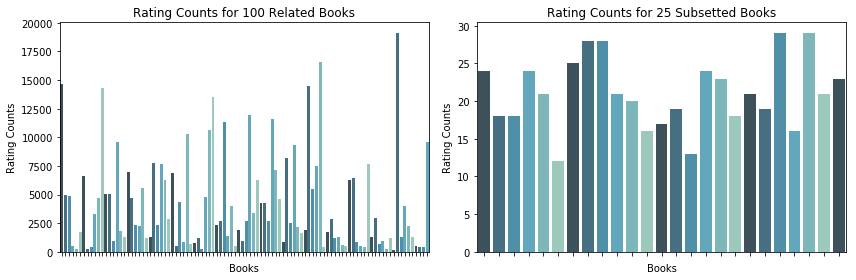

In [260]:
rating_count = pd.DataFrame(recommended.groupby(['title'])['rating'].count()).reset_index()
rand_count = pd.DataFrame(sub.groupby(['title'])['rating'].count()).reset_index()

fig = plt.figure(figsize=(12,4)); ax = fig.subplots(nrows=1, ncols=2)

ax0=sns.catplot(x='title', y="rating", kind="bar",data=rating_count,ax=ax[0],palette=sns.color_palette('GnBu_d')); plt.close()
ax1=sns.catplot(x='title', y="rating", kind="bar",data=rand_count,ax=ax[1], palette=sns.color_palette('GnBu_d')); plt.close()

for ax in fig.axes:
    ax.set_xticklabels([]); ax.set_xlabel("Books"); ax.set_ylabel("Rating Counts")

fig.axes[0].set_title('Rating Counts for 100 Related Books')
fig.axes[1].set_title('Rating Counts for 25 Subsetted Books')

plt.tight_layout()

#### User-Item Matrix

We created two user-item matrices for our SVD calculations. The first binary matrix was used to see the distribution of book ratings. A value of 1 signifies a user rated the title, whereas 0 means the user did not rate the book in our data subset. 

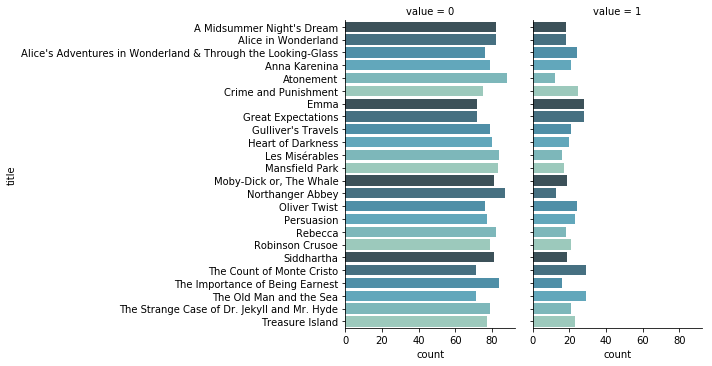

In [289]:
# binary-matrix
binary_matrix=sub.pivot_table(index='user_id', columns='title', values='rating', aggfunc='count', fill_value=0)

# transformation to long dataframe
reset_m=binary_matrix.reset_index(); binary_matrix_long = pd.melt(reset_m, id_vars='user_id', value_vars=list(binary_matrix.columns[1:]), var_name='title', value_name='value')

# view distribution
sns.catplot(x=None, y="title", col="value", kind="count",data=binary_matrix_long, palette=sns.color_palette('GnBu_d'),margin_titles=True);

Our second and primary matrix contains the rating the book received by each user. If no rating was received, the output was coded as 0.

In [319]:
# user-item matrix
rating_matrix=sub.pivot_table(index='user_id', columns='title', values='rating', fill_value=0)

# transformation to long dataframe
reset_m=rating_matrix.reset_index(); rating_matrix_long = pd.melt(reset_m, id_vars='user_id', value_vars=list(rating_matrix.columns[1:]), var_name='title', value_name='rating')

# preview matrix
rating_matrix.head(10)

title,A Christmas Carol,A Midsummer Night's Dream,Alice in Wonderland,Alice's Adventures in Wonderland & Through the Looking-Glass,Anna Karenina,Atonement,Crime and Punishment,Emma,Great Expectations,Gulliver's Travels,...,Oliver Twist,Persuasion,Rebecca,Robinson Crusoe,Siddhartha,The Count of Monte Cristo,The Importance of Being Earnest,The Old Man and the Sea,The Strange Case of Dr. Jekyll and Mr. Hyde,Treasure Island
user_id,,,,,,,,,,,,,,,,,,,,,
110,0,0,1,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,0,0,2
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
321,0,4,4,0,4,0,4,3,4,0,...,0,0,0,0,4,5,0,0,0,0
900,0,0,0,0,0,0,0,3,4,0,...,4,3,0,0,0,0,3,5,0,0
1032,0,3,0,0,3,0,4,0,0,3,...,0,4,0,0,0,0,0,0,0,0
1478,0,4,0,4,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
2955,0,0,0,0,5,0,5,0,0,0,...,0,0,0,0,5,0,5,4,0,0
3310,0,0,2,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3992,0,0,0,0,0,4,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0


We can our ratings matrix to further visualize the distribution of ratings each of our book selections received by our user subset. We know that 1,897 ratings were imputed as 0, thus the histogram below only shows the distributions for our actual user ratings. We can infer from the distribution that our selected books received overall high ratings.  

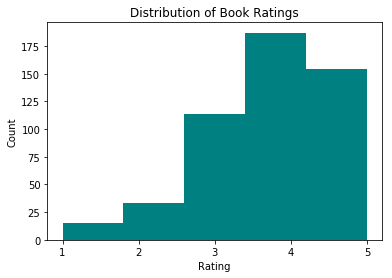

In [354]:
p = plt.hist(rating_matrix_long[rating_matrix_long['rating']>0]['rating'], bins=5, color="teal")
plt.xlabel('Rating', fontsize=10); plt.ylabel('Count', fontsize=10); plt.xticks([1,2,3,4,5]); plt.title('Distribution of Book Ratings'); plt.show()

#### Split Training and Test Data

Our final pre-processing step requires us to split our data into training and test sets. We chose a small test size of .1 based on the small availability of user-ratings per each novel. 

In [97]:
#### FROM RAJ's work
#### Uncertain if this is necessary.... SHOULD WE BE USING rating_matrix_long HERE??
subset = sub[['user_id','title','rating']] 

# load dataset into suprise format from a pandas datafram
reader = Reader(rating_scale=(1,5)) # sets upper and lower limit of the SVD rating 
SVD_df = Dataset.load_from_df(subset,reader) 

# split data into train and test sets
train_set, test_set = train_test_split(SVD_df,random_state=1,test_size=.10)

**GROUP NOTES:**

Raj's SVD model is based off a subset from our recommended titles. The subset includes only ratings from users that we have. I created a long_matrix in the pre-processing stage which fills 0 in book ratings that we don't have from users. 

I am uncertain which method is correct. As you can see from my test below, however, the base dataset for our SVD predictions will have an affect on our overall outcome. Please recommend and select the proper dataset for the suprise calculations.

In [137]:
#### JULIANN COMPARISON: compare subset vs long matrix ratings. long matrix includes 0 for user/book combos without ratings. 
algo = SVD() # set SVD algorithm

## SUBSET TEST
# Train the algorithm on the trainset, and predict ratings for the testset
predictions1 = algo.fit(train_set).test(test_set)

# RMSE calculation
rmse1=accuracy.rmse(predictions1)

## RATING_MATRIX_LONG TEST
SVD_df2 = Dataset.load_from_df(rating_matrix_long,reader)
train_set2\, test_set2 = train_test_split(SVD_df2,random_state=1,test_size=.10)
# Train the algorithm on the trainset, and predict ratings for the testset
predictions2 = algo.fit(train_set2).test(test_set2)

# RMSE calculation
rmse2=accuracy.rmse(predictions2)

print("SUBSET SHAPE:", subset.shape, "\nLONG MATRIX SHAPE:",rating_matrix_long.shape)
print("SUBSET PRED LENGTH:", len(predictions1), "\nLONG MATRIX PRED LENGTH:",len(predictions2))

RMSE: 1.0398
RMSE: 1.6164
SUBSET SHAPE: (527, 3) 
LONG MATRIX SHAPE: (2400, 3)
SUBSET PRED LENGTH: 105 
LONG MATRIX PRED LENGTH: 240


<h2 style="color:#088A68;">Surprise: Singular Value Decomposition</h2>

We calculated SVD using the `suprise` package. Add more notes and section headings to explain steps. 

In [17]:
# Train a SVD Model with 5 Latent factor 
#Latetnt feature matrix created 
svd_model = SVD(n_factors=5)
svd_model.fit(train_set)

In [18]:
svd_model.qi.shape

(25, 5)

In [19]:
svd_model.pu.shape

(99, 5)

In [20]:
svd_model.trainset

In [21]:
# In SVD every item is link to an number, by using _raw2inner_id_items 
# we can see the correspoding ID of the Item i.e. Book

type(svd_model.trainset._raw2inner_id_items)
# Dict for Item from latent feature 
idx_item_d = svd_model.trainset._raw2inner_id_items

#Dict for User from latent feature 
idx_user_d =svd_model.trainset._raw2inner_id_users

In [22]:
# dataframe of book with latent Feature ID
idx_book = pd.DataFrame(idx_item_d.items(), columns=['Book_Title', 'Book_Feature_Id'])
idx_book.head()

,Book_Title,Book_Feature_Id
0,Treasure Island,0
1,Mansfield Park,1
2,Oliver Twist,2
3,Persuasion,3
4,Crime and Punishment,4


In [23]:
# dataframe of User with latent Feature ID
idx_user = pd.DataFrame(idx_user_d.items(), columns=['User', 'User_Feature_Id'])
idx_user.head()

,User,User_Feature_Id
0,20749,0
1,42302,1
2,23902,2
3,43927,3
4,6903,4


In [24]:
# let find the latent feature vector for 'The Count of Monte Cristo'

print (idx_item_d.get('The Count of Monte Cristo'))
idx_book[idx_book.Book_Title=="The Count of Monte Cristo"]



12


,Book_Title,Book_Feature_Id
12,The Count of Monte Cristo,12


In [25]:
# Now lets find latent feature for this 'Frankenstein' which at index of 1 of feature latent matrix 


print("Each book has {} latent features.".format(svd_model.qi[1].shape[0]))
svd_model.qi[1]

Each book has 5 latent features.


array([-0.06229301,  0.07728503,  0.16122763, -0.02915811,  0.02191538])

In [138]:
#preview rating matrix (repeat - probs delete from this section)
rating_matrix.head(10)

title,A Christmas Carol,A Midsummer Night's Dream,Alice in Wonderland,Alice's Adventures in Wonderland & Through the Looking-Glass,Anna Karenina,Atonement,Crime and Punishment,Emma,Great Expectations,Gulliver's Travels,...,Oliver Twist,Persuasion,Rebecca,Robinson Crusoe,Siddhartha,The Count of Monte Cristo,The Importance of Being Earnest,The Old Man and the Sea,The Strange Case of Dr. Jekyll and Mr. Hyde,Treasure Island
user_id,,,,,,,,,,,,,,,,,,,,,
110,0,0,1,0,0,0,0,0,0,0,...,0,0,2,2,0,0,0,0,0,2
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
321,0,4,4,0,4,0,4,3,4,0,...,0,0,0,0,4,5,0,0,0,0
900,0,0,0,0,0,0,0,3,4,0,...,4,3,0,0,0,0,3,5,0,0
1032,0,3,0,0,3,0,4,0,0,3,...,0,4,0,0,0,0,0,0,0,0
1478,0,4,0,4,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
2955,0,0,0,0,5,0,5,0,0,0,...,0,0,0,0,5,0,5,4,0,0
3310,0,0,2,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3992,0,0,0,0,0,4,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0


In [27]:
# checking Predicted rating Vs Actaul Rating of the Book
def get_book_rating(svdModel,MainData,tuser,tbook):
    act_Rate = MainData[( MainData['title'] == tbook ) & (subset['user_id'] == int(tuser))].rating
    return act_Rate, svdModel.predict(tuser,tbook)


In [28]:
test_user = '321'
test_book ="Alice in Wonderland"

# All_Data[( All_Data['title'] == 'Gulliver\'s Travels' ) & (All_Data['user_id'] == int(test_user))].rating

check  , result = get_book_rating(svd_model,subset,'321','Alice in Wonderland')
print('Actual Rating: {}'. format(check.values[0]))
print(result)

Actual Rating: 4
user: 321        item: Alice in Wonderland r_ui = None   est = 3.61   {'was_impossible': False}


In [29]:

check  , result = get_book_rating(svd_model,subset,'110','Treasure Island')
print('Actual Rating: {}'. format(check.values[0]))
print(result)

Actual Rating: 2
user: 110        item: Treasure Island r_ui = None   est = 3.74   {'was_impossible': False}


In [30]:
# Perfrom the test on test_set using the Model svd_model with 5 latent Feature
predictions = svd_model.test(test_set)

# check the RMSE for the test set using the SVD model
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 0.9909


0.9909453535333493

In [31]:
avg_rmse=[]

for i in range(100):
    train_set, test_set = train_test_split(SVD_df,test_size=.90)
    predictions = svd_model.test(test_set)
    # check the RMSE for the test set using the SVD model
    # print("User-based Model : Test Set")
    avg_rmse.append(accuracy.rmse(predictions, verbose=False))

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


mean(avg_rmse)

0.8579762291975486

In [32]:
# Using Cosine similarty among the vector find similar Book
from scipy import spatial

idx_item_d.get('Crime and Punishment')

vector_book1 = svd_model.qi[idx_item_d.get('Atonement')]
print('Latent vector for Book {} : {}'.format('Atonement',vector_book1))
vector_book2 = svd_model.qi[idx_item_d.get('Oliver Twist')]
print('Latent vector for Book {} : {}'.format('Oliver Twist',vector_book1))

# Cosine Distance 
vector_cosine =1-spatial.distance.cosine(vector_book1,vector_book2)
print('Cosine similarlity for Latent vector for Book {} {}: {}'.format('Atonement','Oliver Twist',vector_cosine))



Latent vector for Book Atonement : [-0.16525714  0.10605802  0.09821018 -0.02612828  0.0840365 ]
Latent vector for Book Oliver Twist : [-0.16525714  0.10605802  0.09821018 -0.02612828  0.0840365 ]
Cosine similarlity for Latent vector for Book Atonement Oliver Twist: 0.6358355160038923


In [33]:
len(idx_book.Book_Title)


25

In [34]:
# # Here we are listing all the book and corresponding cosine similarty with all the other book
# Cosine similarity of movies latent feature vector 
# items_dic

items_dic = {}
len(svd_model.qi)
for i in range (len(idx_book.Book_Title)):
    cosine = {}
    vect1_book = [i for i in svd_model.qi[idx_item_d.get(idx_book.Book_Title[i])]]
#     items_dic[idx_book.Book_Title[i]] = vect1_book  
    for k in range (len(svd_model.qi)):
        cosine[idx_book.Book_Title[k]] = 1- spatial.distance.cosine(vect1_book,svd_model.qi[k])
#         cosine[(1- spatial.distance.cosine(vect1_book,svd_model.qi[k]))] =  idx_book.Book_Title[k]
    sorted_x = sorted(cosine.items(), key=lambda kv: kv[1],reverse=True)
    items_dic[idx_book.Book_Title[i]] = sorted_x  
    

# Method to show N item from Dict
def show_dict_item(n, dict_obj):
    return {k: dict_obj[k] for k in list(dict_obj)[:n]}

# build Final Recommendation by Book Title 
# Not Dropping the books already read by user 
def get_book_recommendation(title,number_of_rec=5):
    Rec_Order = items_dic.get(title)
    return Rec_Order[1:6]


print(show_dict_item(2,items_dic))


{'Treasure Island': [('Treasure Island', 1.0), ('The Old Man and the Sea', 0.7988994975755934), ('The Strange Case of Dr. Jekyll and Mr. Hyde', 0.7956605581436372), ('Moby-Dick or, The Whale', 0.7889869507521348), ('Rebecca', 0.7757482754843034), ('Emma', 0.7433406612583697), ('Robinson Crusoe', 0.7338236423700613), ('The Importance of Being Earnest', 0.6219209408774289), ('Northanger Abbey', 0.5386587485250832), ('Heart of Darkness', 0.5011059888275259), ('Persuasion', 0.31113964095070656), ('Atonement', 0.19025523494501273), ("Gulliver's Travels", 0.1358537346043791), ('Les Misérables', -0.07696061012609023), ('Mansfield Park', -0.10636443476150781), ('Oliver Twist', -0.11575268462051369), ('Crime and Punishment', -0.16108553797442626), ("A Midsummer Night's Dream", -0.320935136417271), ('Anna Karenina', -0.33271799094532994), ('A Christmas Carol', -0.37437593448660245), ("Alice's Adventures in Wonderland & Through the Looking-Glass", -0.45742092831732317), ('Siddhartha', -0.48156211

In [35]:
# Recommend top 5 book by Book Title 'Lord of the Flies'
get_book_recommendation('Robinson Crusoe')

[('Treasure Island', 0.7338236423700613),
 ('Moby-Dick or, The Whale', 0.720277559835491),
 ('Persuasion', 0.5846852834416517),
 ('The Strange Case of Dr. Jekyll and Mr. Hyde', 0.5845878171687164),
 ('The Importance of Being Earnest', 0.5552692121270447)]

In [36]:
get_book_recommendation('Heart of Darkness')

[('Emma', 0.9036849738892241),
 ('Atonement', 0.787608372785351),
 ('The Strange Case of Dr. Jekyll and Mr. Hyde', 0.7415328357756368),
 ('Mansfield Park', 0.6943925718270056),
 ('Rebecca', 0.5879453249590992)]

In [37]:
#to get the Dict from item_dic dict for movie 'Frankenstein'
Rec_Order = items_dic.get('A Midsummer Night\'s Dream')
Rec_Order

[("A Midsummer Night's Dream", 1.0),
 ('The Count of Monte Cristo', 0.9070255893855291),
 ('Siddhartha', 0.5260602239433709),
 ("Alice's Adventures in Wonderland & Through the Looking-Glass",
  0.4887151171281523),
 ('Atonement', 0.4749297880374246),
 ('Mansfield Park', 0.47427552570638465),
 ('Les Misérables', 0.35228620439166336),
 ('Crime and Punishment', 0.24597118679634333),
 ('Northanger Abbey', 0.2359809476211172),
 ("Gulliver's Travels", 0.23418442210784018),
 ('Oliver Twist', 0.16995266489777028),
 ('Emma', 0.06706823476093882),
 ('Alice in Wonderland', 0.062261498882141386),
 ('Heart of Darkness', -0.027509980014350566),
 ('Rebecca', -0.05300109505875805),
 ('The Old Man and the Sea', -0.1970329895993399),
 ('Great Expectations', -0.25745898390122934),
 ('Moby-Dick or, The Whale', -0.28726583314715803),
 ('Treasure Island', -0.320935136417271),
 ('The Importance of Being Earnest', -0.44875705384429043),
 ('Robinson Crusoe', -0.5000418906202797),
 ('The Strange Case of Dr. Jek

<h2 style="color:#088A68;">SVD Method</h2>
Just playing around to compare output of full matrix to subset in section above. Delete upon final submission. 

ValueError: x and y must be the same size

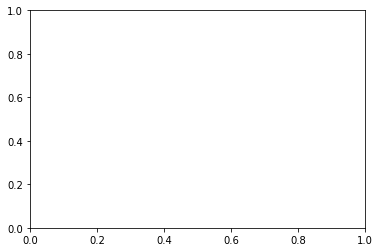

In [151]:
from sklearn.model_selection import train_test_split as tts

train, test = tts(rating_matrix_long, test_size=0.1, random_state=42)


plt.scatter(train,test,c='red')
plt.xticks(rotation='vertical')
plt.show()

In [44]:
u,s,vh = np.linalg.svd(rating_matrix)

print("SVD Matrices (preview of first array):", 
      "\n\n U Matrix:", u.shape, "\n", u[1], 
      "\n\nDiagonal Matrix, S:", s.shape, "\n", s[1], 
      "\n\nV transpose Matrix:",  vh.shape, "\n", vh[1])

SVD Matrices (preview of first array): 

 U Matrix: (100, 100) 
 [-0.01120756 -0.00678445 -0.04709354 -0.02870684 -0.01341654 -0.00961657
  0.07501355 -0.0569513   0.01723017  0.02284097  0.09537052  0.03325205
 -0.05901578 -0.02758378 -0.07368036  0.03375414  0.10010004 -0.03051419
 -0.05347726 -0.00608622  0.02415425  0.00147812  0.1846887  -0.14177129
  0.01051505  0.04768404  0.00866983  0.01282072 -0.10841531 -0.01345995
 -0.0333691   0.03294646 -0.04617272  0.03937801  0.03780076  0.05863721
 -0.11725606  0.07284992  0.06388137  0.04734471 -0.02565962  0.07022259
 -0.23549178 -0.07972298  0.14558784 -0.12124379  0.03077447  0.010696
 -0.1623732  -0.06305642 -0.15921912  0.07519515 -0.16629822  0.09999541
 -0.06481355 -0.29394372 -0.03319562 -0.06769715  0.07528611 -0.26632285
  0.03993678 -0.00290419 -0.25545172 -0.05479226  0.02504731 -0.0219364
  0.01696979  0.02121386  0.06982215  0.04832154 -0.05094973 -0.05835585
 -0.01385966  0.04390167 -0.31790475  0.03707686  0.02254108 -

<h2 style="color:#088A68;">Surprise!</h2>

<h2 style="color:#088A68;">Analysis</h2>

---
#### References: 
*  **[Goodbooks-10k:](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/)** A New Dataset for Book Recommendations